# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
!"C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi.exe"

Sun Mar 31 02:10:20 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 399.24                 Driver Version: 399.24                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 970    WDDM  | 00000000:01:00.0  On |                  N/A |
| 43%   40C    P2    53W / 250W |   1974MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
import keras
import tensorflow as tf
import itertools

from numba import cuda
cuda.select_device(0)
cuda.close()

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
def build_mlp(input_shape=x_train.shape[1:], output_units=y_train.shape[-1], num_neurons=[256, 128, 64, 32]):
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation='relu',
                                   name='hidden_layers'+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation='relu',
                                   name='hidden_layers'+str(i+1))(x)
        
    output_layer = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

In [7]:
## 超參數設定
optimizers = ['SGD', 'RMSprop', 'AdaGrad', 'Adam']

learning_rates = [1e-2, 1e-3, 1e-4]

epochs = 100

batch_size = 512

In [8]:
def model_fitting( learning_rate, optimizer, epochs, batch_size, input_shape=x_train.shape[1:] ):
    
    keras.backend.clear_session()
    
    ##################################################
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    ##################################################

    model = build_mlp(input_shape=input_shape)
    model.summary()
    
    selector = {'SGD': keras.optimizers.SGD(lr=learning_rate, momentum=0.95, nesterov=True),
                'RMSprop': keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None),
                'AdaGrad': keras.optimizers.Adagrad(lr=learning_rate, epsilon=None), 
                'Adam': keras.optimizers.Adam(lr=learning_rate, epsilon=None, amsgrad=True)}
    
    optimizer = selector.get(optimizer)
    
    
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    
    history = model.fit(x_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(x_test, y_test), 
                        shuffle=True)
    #################
    sess.close()
    #################
    
    return history

In [9]:
results = {}

for lr, opt in itertools.product(learning_rates, optimizers):
    
    history = model_fitting(learning_rate=lr,
                            optimizer=opt, 
                            epochs=epochs, 
                            batch_size=batch_size)
    
    name_tag = f'{opt}, lr={lr}'
    results[name_tag] = {'train_loss': history.history['loss'],
                         'valid_loss': history.history['val_loss'],
                         'train_acc': history.history['acc'],
                         'valid_acc': history.history['val_acc']}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layers1 (Dense)       (None, 256)               786688    
_________________________________________________________________
hidden_layers2 (Dense)       (None, 128)               32896     
_________________________________________________________________
hidden_layers3 (Dense)       (None, 64)                8256      
_________________________________________________________________
hidden_layers4 (Dense)       (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 10)                330       
Total params: 830,250
Trainable params: 830,250
Non-trainable params: 0
_________________________________________________________________
Trai

50000/50000 [==============================] - 3s 50us/step - loss: 0.5967 - acc: 0.7860 - val_loss: 1.9045 - val_acc: 0.5060
Epoch 52/100
50000/50000 [==============================] - 2s 49us/step - loss: 0.5830 - acc: 0.7909 - val_loss: 1.8132 - val_acc: 0.5141
Epoch 53/100
50000/50000 [==============================] - 2s 48us/step - loss: 0.5861 - acc: 0.7895 - val_loss: 1.8271 - val_acc: 0.5259
Epoch 54/100
50000/50000 [==============================] - 3s 52us/step - loss: 0.5590 - acc: 0.7984 - val_loss: 1.8239 - val_acc: 0.5193
Epoch 55/100
50000/50000 [==============================] - 3s 50us/step - loss: 0.5533 - acc: 0.8002 - val_loss: 2.0033 - val_acc: 0.5129
Epoch 56/100
50000/50000 [==============================] - 3s 50us/step - loss: 0.5393 - acc: 0.8059 - val_loss: 1.9377 - val_acc: 0.5158
Epoch 57/100
50000/50000 [==============================] - 3s 50us/step - loss: 0.5461 - acc: 0.8043 - val_loss: 1.9793 - val_acc: 0.5227
Epoch 58/100
50000/50000 [==============

50000/50000 [==============================] - 3s 57us/step - loss: 14.3789 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/100
50000/50000 [==============================] - 2s 50us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/100
50000/50000 [==============================] - 3s 50us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/100
50000/50000 [==============================] - 3s 51us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/100
50000/50000 [==============================] - 2s 50us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/100
50000/50000 [==============================] - 3s 52us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/100
50000/50000 [==============================] - 3s 52us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 8/100
50000/50000 [=======

50000/50000 [==============================] - 3s 51us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 60/100
50000/50000 [==============================] - 3s 53us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 61/100
50000/50000 [==============================] - 3s 55us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 62/100
50000/50000 [==============================] - 3s 51us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 63/100
50000/50000 [==============================] - 2s 50us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 64/100
50000/50000 [==============================] - 3s 50us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 65/100
50000/50000 [==============================] - 2s 50us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 66/100
50000/50000 [

50000/50000 [==============================] - 3s 51us/step - loss: 1.7093 - acc: 0.3918 - val_loss: 1.7190 - val_acc: 0.3847
Epoch 10/100
50000/50000 [==============================] - 3s 53us/step - loss: 1.6926 - acc: 0.3991 - val_loss: 1.6834 - val_acc: 0.4006
Epoch 11/100
50000/50000 [==============================] - 3s 50us/step - loss: 1.6649 - acc: 0.4084 - val_loss: 1.6797 - val_acc: 0.3897
Epoch 12/100
50000/50000 [==============================] - 2s 49us/step - loss: 1.6460 - acc: 0.4152 - val_loss: 1.6271 - val_acc: 0.4193
Epoch 13/100
50000/50000 [==============================] - 3s 50us/step - loss: 1.6238 - acc: 0.4225 - val_loss: 1.6202 - val_acc: 0.4262
Epoch 14/100
50000/50000 [==============================] - 2s 49us/step - loss: 1.6142 - acc: 0.4265 - val_loss: 1.6287 - val_acc: 0.4208
Epoch 15/100
50000/50000 [==============================] - 3s 50us/step - loss: 1.5974 - acc: 0.4320 - val_loss: 1.5972 - val_acc: 0.4253
Epoch 16/100
50000/50000 [==============

50000/50000 [==============================] - 3s 52us/step - loss: 1.2326 - acc: 0.5631 - val_loss: 1.3868 - val_acc: 0.5119
Epoch 69/100
50000/50000 [==============================] - 2s 50us/step - loss: 1.2249 - acc: 0.5655 - val_loss: 1.4097 - val_acc: 0.5096
Epoch 70/100
50000/50000 [==============================] - 2s 50us/step - loss: 1.2213 - acc: 0.5677 - val_loss: 1.4178 - val_acc: 0.5021
Epoch 71/100
50000/50000 [==============================] - 3s 50us/step - loss: 1.2231 - acc: 0.5676 - val_loss: 1.3837 - val_acc: 0.5151
Epoch 72/100
50000/50000 [==============================] - 3s 51us/step - loss: 1.2152 - acc: 0.5698 - val_loss: 1.3779 - val_acc: 0.5131
Epoch 73/100
50000/50000 [==============================] - 2s 50us/step - loss: 1.2108 - acc: 0.5713 - val_loss: 1.3742 - val_acc: 0.5180
Epoch 74/100
50000/50000 [==============================] - 3s 51us/step - loss: 1.2071 - acc: 0.5728 - val_loss: 1.4276 - val_acc: 0.5016
Epoch 75/100
50000/50000 [==============

50000/50000 [==============================] - 3s 52us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 19/100
50000/50000 [==============================] - 3s 53us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 20/100
50000/50000 [==============================] - 3s 53us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 21/100
50000/50000 [==============================] - 3s 55us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 22/100
50000/50000 [==============================] - 3s 52us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 23/100
50000/50000 [==============================] - 3s 54us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 24/100
50000/50000 [==============================] - 3s 52us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 25/100
50000/50000 [

50000/50000 [==============================] - 3s 52us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 77/100
50000/50000 [==============================] - 3s 52us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 78/100
50000/50000 [==============================] - 3s 52us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 79/100
50000/50000 [==============================] - 3s 51us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 80/100
50000/50000 [==============================] - 3s 51us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 81/100
50000/50000 [==============================] - 3s 51us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 82/100
50000/50000 [==============================] - 3s 51us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 83/100
50000/50000 [

50000/50000 [==============================] - 3s 51us/step - loss: 1.4035 - acc: 0.5022 - val_loss: 1.4611 - val_acc: 0.4779
Epoch 27/100
50000/50000 [==============================] - 2s 48us/step - loss: 1.3938 - acc: 0.5037 - val_loss: 1.4556 - val_acc: 0.4784
Epoch 28/100
50000/50000 [==============================] - 2s 49us/step - loss: 1.3796 - acc: 0.5106 - val_loss: 1.4338 - val_acc: 0.4821
Epoch 29/100
50000/50000 [==============================] - 2s 50us/step - loss: 1.3689 - acc: 0.5124 - val_loss: 1.4463 - val_acc: 0.4787
Epoch 30/100
50000/50000 [==============================] - 3s 51us/step - loss: 1.3594 - acc: 0.5163 - val_loss: 1.4282 - val_acc: 0.4875
Epoch 31/100
50000/50000 [==============================] - 3s 52us/step - loss: 1.3494 - acc: 0.5213 - val_loss: 1.4279 - val_acc: 0.4865
Epoch 32/100
50000/50000 [==============================] - 2s 49us/step - loss: 1.3357 - acc: 0.5253 - val_loss: 1.4299 - val_acc: 0.4920
Epoch 33/100
50000/50000 [==============

50000/50000 [==============================] - 3s 57us/step - loss: 0.9407 - acc: 0.6652 - val_loss: 1.4340 - val_acc: 0.5196
Epoch 86/100
50000/50000 [==============================] - 2s 50us/step - loss: 0.9319 - acc: 0.6688 - val_loss: 1.4125 - val_acc: 0.5217
Epoch 87/100
50000/50000 [==============================] - 3s 56us/step - loss: 0.9324 - acc: 0.6693 - val_loss: 1.4717 - val_acc: 0.5120
Epoch 88/100
50000/50000 [==============================] - 4s 84us/step - loss: 0.9110 - acc: 0.6751 - val_loss: 1.4102 - val_acc: 0.5251
Epoch 89/100
50000/50000 [==============================] - 5s 104us/step - loss: 0.9156 - acc: 0.6730 - val_loss: 1.4360 - val_acc: 0.5178
Epoch 90/100
50000/50000 [==============================] - 4s 74us/step - loss: 0.8952 - acc: 0.6809 - val_loss: 1.4482 - val_acc: 0.5144
Epoch 91/100
50000/50000 [==============================] - 3s 64us/step - loss: 0.9021 - acc: 0.6786 - val_loss: 1.4835 - val_acc: 0.5119
Epoch 92/100
50000/50000 [=============

50000/50000 [==============================] - 3s 51us/step - loss: 1.2960 - acc: 0.5400 - val_loss: 1.5419 - val_acc: 0.4707
Epoch 36/100
50000/50000 [==============================] - 3s 52us/step - loss: 1.2875 - acc: 0.5414 - val_loss: 1.5246 - val_acc: 0.4723
Epoch 37/100
50000/50000 [==============================] - 3s 52us/step - loss: 1.2831 - acc: 0.5435 - val_loss: 1.4789 - val_acc: 0.4790
Epoch 38/100
50000/50000 [==============================] - 3s 51us/step - loss: 1.2690 - acc: 0.5456 - val_loss: 1.5256 - val_acc: 0.4607
Epoch 39/100
50000/50000 [==============================] - 3s 54us/step - loss: 1.2615 - acc: 0.5492 - val_loss: 1.4402 - val_acc: 0.4972
Epoch 40/100
50000/50000 [==============================] - 3s 52us/step - loss: 1.2564 - acc: 0.5529 - val_loss: 1.4865 - val_acc: 0.4885
Epoch 41/100
50000/50000 [==============================] - 3s 51us/step - loss: 1.2507 - acc: 0.5538 - val_loss: 1.4696 - val_acc: 0.4879
Epoch 42/100
50000/50000 [==============

50000/50000 [==============================] - 3s 52us/step - loss: 0.9438 - acc: 0.6626 - val_loss: 1.6265 - val_acc: 0.4936
Epoch 95/100
50000/50000 [==============================] - 3s 51us/step - loss: 0.9419 - acc: 0.6622 - val_loss: 1.6568 - val_acc: 0.4931
Epoch 96/100
50000/50000 [==============================] - 3s 51us/step - loss: 0.9365 - acc: 0.6648 - val_loss: 1.6691 - val_acc: 0.4900
Epoch 97/100
50000/50000 [==============================] - 3s 52us/step - loss: 0.9362 - acc: 0.6649 - val_loss: 1.6371 - val_acc: 0.4810
Epoch 98/100
50000/50000 [==============================] - 3s 51us/step - loss: 0.9287 - acc: 0.6666 - val_loss: 1.6374 - val_acc: 0.4970
Epoch 99/100
50000/50000 [==============================] - 3s 52us/step - loss: 0.9258 - acc: 0.6684 - val_loss: 1.6656 - val_acc: 0.4807
Epoch 100/100
50000/50000 [==============================] - 3s 51us/step - loss: 0.9234 - acc: 0.6696 - val_loss: 1.6076 - val_acc: 0.5000
_______________________________________

50000/50000 [==============================] - 2s 50us/step - loss: 1.4440 - acc: 0.4935 - val_loss: 1.4840 - val_acc: 0.4746
Epoch 45/100
50000/50000 [==============================] - 2s 49us/step - loss: 1.4404 - acc: 0.4945 - val_loss: 1.4868 - val_acc: 0.4703
Epoch 46/100
50000/50000 [==============================] - 2s 49us/step - loss: 1.4389 - acc: 0.4948 - val_loss: 1.4759 - val_acc: 0.4763
Epoch 47/100
50000/50000 [==============================] - 3s 50us/step - loss: 1.4340 - acc: 0.4968 - val_loss: 1.4773 - val_acc: 0.4737
Epoch 48/100
50000/50000 [==============================] - 3s 52us/step - loss: 1.4301 - acc: 0.4993 - val_loss: 1.4740 - val_acc: 0.4768
Epoch 49/100
50000/50000 [==============================] - 3s 54us/step - loss: 1.4262 - acc: 0.4995 - val_loss: 1.4687 - val_acc: 0.4808
Epoch 50/100
50000/50000 [==============================] - 3s 57us/step - loss: 1.4242 - acc: 0.5012 - val_loss: 1.4716 - val_acc: 0.4782
Epoch 51/100
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 4s 84us/step - loss: 2.0293 - acc: 0.2635 - val_loss: 1.8927 - val_acc: 0.3241
Epoch 2/100
50000/50000 [==============================] - 3s 70us/step - loss: 1.8086 - acc: 0.3527 - val_loss: 1.7328 - val_acc: 0.3851
Epoch 3/100
50000/50000 [==============================] - 3s 69us/step - loss: 1.7163 - acc: 0.3885 - val_loss: 1.6699 - val_acc: 0.4097
Epoch 4/100
50000/50000 [==============================] - 4s 72us/step - loss: 1.6547 - acc: 0.4142 - val_loss: 1.6544 - val_acc: 0.4191
Epoch 5/100
50000/50000 [==============================] - 4s 76us/step - loss: 1.6170 - acc: 0.4272 - val_loss: 1.5877 - val_acc: 0.4343
Epoch 6/100
50000/50000 [==============================] - 4s 72us/step - loss: 1.5670 - acc: 0.4441 - val_loss: 1.5645 - val_acc: 0.4459
Epoch 7/100
50000/50000 [==============================] - 4s 76us/step - loss: 1.5320 - acc: 0.4559 - val_loss: 1.5267 - 

50000/50000 [==============================] - 3s 66us/step - loss: 0.9792 - acc: 0.6511 - val_loss: 1.4900 - val_acc: 0.5138
Epoch 60/100
50000/50000 [==============================] - 3s 65us/step - loss: 0.9551 - acc: 0.6628 - val_loss: 1.4570 - val_acc: 0.5236
Epoch 61/100
50000/50000 [==============================] - 3s 64us/step - loss: 0.9551 - acc: 0.6607 - val_loss: 1.4428 - val_acc: 0.5261
Epoch 62/100
50000/50000 [==============================] - 3s 65us/step - loss: 0.9448 - acc: 0.6615 - val_loss: 1.4554 - val_acc: 0.5230
Epoch 63/100
50000/50000 [==============================] - 3s 66us/step - loss: 0.9384 - acc: 0.6643 - val_loss: 1.4878 - val_acc: 0.5277
Epoch 64/100
50000/50000 [==============================] - 3s 64us/step - loss: 0.9460 - acc: 0.6646 - val_loss: 1.4667 - val_acc: 0.5166
Epoch 65/100
50000/50000 [==============================] - 3s 64us/step - loss: 0.9351 - acc: 0.6667 - val_loss: 1.5138 - val_acc: 0.5177
Epoch 66/100
50000/50000 [==============

50000/50000 [==============================] - 3s 62us/step - loss: 2.1709 - acc: 0.2041 - val_loss: 2.1629 - val_acc: 0.2077
Epoch 10/100
50000/50000 [==============================] - 3s 61us/step - loss: 2.1560 - acc: 0.2124 - val_loss: 2.1481 - val_acc: 0.2174
Epoch 11/100
50000/50000 [==============================] - 3s 61us/step - loss: 2.1407 - acc: 0.2207 - val_loss: 2.1327 - val_acc: 0.2221
Epoch 12/100
50000/50000 [==============================] - 3s 63us/step - loss: 2.1253 - acc: 0.2276 - val_loss: 2.1172 - val_acc: 0.2303
Epoch 13/100
50000/50000 [==============================] - 3s 64us/step - loss: 2.1095 - acc: 0.2362 - val_loss: 2.1013 - val_acc: 0.2401
Epoch 14/100
50000/50000 [==============================] - 3s 62us/step - loss: 2.0931 - acc: 0.2447 - val_loss: 2.0851 - val_acc: 0.2483
Epoch 15/100
50000/50000 [==============================] - 3s 61us/step - loss: 2.0765 - acc: 0.2529 - val_loss: 2.0687 - val_acc: 0.2551
Epoch 16/100
50000/50000 [==============

50000/50000 [==============================] - 3s 64us/step - loss: 1.7339 - acc: 0.3870 - val_loss: 1.7352 - val_acc: 0.3856
Epoch 69/100
50000/50000 [==============================] - 3s 62us/step - loss: 1.7308 - acc: 0.3883 - val_loss: 1.7319 - val_acc: 0.3881
Epoch 70/100
50000/50000 [==============================] - 3s 63us/step - loss: 1.7278 - acc: 0.3888 - val_loss: 1.7297 - val_acc: 0.3892
Epoch 71/100
50000/50000 [==============================] - 3s 62us/step - loss: 1.7253 - acc: 0.3900 - val_loss: 1.7272 - val_acc: 0.3912
Epoch 72/100
50000/50000 [==============================] - 3s 62us/step - loss: 1.7227 - acc: 0.3909 - val_loss: 1.7238 - val_acc: 0.3911
Epoch 73/100
50000/50000 [==============================] - 3s 63us/step - loss: 1.7199 - acc: 0.3923 - val_loss: 1.7212 - val_acc: 0.3919
Epoch 74/100
50000/50000 [==============================] - 3s 61us/step - loss: 1.7170 - acc: 0.3924 - val_loss: 1.7190 - val_acc: 0.3928
Epoch 75/100
50000/50000 [==============

50000/50000 [==============================] - 3s 64us/step - loss: 1.5469 - acc: 0.4554 - val_loss: 1.6059 - val_acc: 0.4235
Epoch 19/100
50000/50000 [==============================] - 3s 65us/step - loss: 1.5363 - acc: 0.4595 - val_loss: 1.5789 - val_acc: 0.4440
Epoch 20/100
50000/50000 [==============================] - 3s 62us/step - loss: 1.5275 - acc: 0.4621 - val_loss: 1.5350 - val_acc: 0.4552
Epoch 21/100
50000/50000 [==============================] - 3s 63us/step - loss: 1.5101 - acc: 0.4684 - val_loss: 1.5518 - val_acc: 0.4436
Epoch 22/100
50000/50000 [==============================] - 3s 62us/step - loss: 1.5041 - acc: 0.4708 - val_loss: 1.5227 - val_acc: 0.4568
Epoch 23/100
50000/50000 [==============================] - 3s 61us/step - loss: 1.4965 - acc: 0.4718 - val_loss: 1.5282 - val_acc: 0.4584
Epoch 24/100
50000/50000 [==============================] - 3s 65us/step - loss: 1.4879 - acc: 0.4770 - val_loss: 1.5264 - val_acc: 0.4533
Epoch 25/100
50000/50000 [==============

50000/50000 [==============================] - 3s 62us/step - loss: 1.1823 - acc: 0.5858 - val_loss: 1.3840 - val_acc: 0.5074
Epoch 78/100
50000/50000 [==============================] - 3s 63us/step - loss: 1.1789 - acc: 0.5881 - val_loss: 1.3755 - val_acc: 0.5116
Epoch 79/100
50000/50000 [==============================] - 3s 62us/step - loss: 1.1781 - acc: 0.5870 - val_loss: 1.3475 - val_acc: 0.5285
Epoch 80/100
50000/50000 [==============================] - 3s 64us/step - loss: 1.1722 - acc: 0.5895 - val_loss: 1.3848 - val_acc: 0.5118
Epoch 81/100
50000/50000 [==============================] - 3s 64us/step - loss: 1.1704 - acc: 0.5906 - val_loss: 1.3738 - val_acc: 0.5203
Epoch 82/100
50000/50000 [==============================] - 3s 63us/step - loss: 1.1690 - acc: 0.5908 - val_loss: 1.3699 - val_acc: 0.5183
Epoch 83/100
50000/50000 [==============================] - 3s 62us/step - loss: 1.1592 - acc: 0.5928 - val_loss: 1.4366 - val_acc: 0.4897
Epoch 84/100
50000/50000 [==============

50000/50000 [==============================] - 3s 62us/step - loss: 1.8713 - acc: 0.3571 - val_loss: 1.8727 - val_acc: 0.3557
Epoch 28/100
50000/50000 [==============================] - 3s 64us/step - loss: 1.8675 - acc: 0.3577 - val_loss: 1.8687 - val_acc: 0.3565
Epoch 29/100
50000/50000 [==============================] - 3s 64us/step - loss: 1.8634 - acc: 0.3595 - val_loss: 1.8649 - val_acc: 0.3589
Epoch 30/100
50000/50000 [==============================] - 3s 64us/step - loss: 1.8593 - acc: 0.3601 - val_loss: 1.8611 - val_acc: 0.3577
Epoch 31/100
50000/50000 [==============================] - 3s 63us/step - loss: 1.8555 - acc: 0.3612 - val_loss: 1.8573 - val_acc: 0.3594
Epoch 32/100
50000/50000 [==============================] - 3s 63us/step - loss: 1.8518 - acc: 0.3630 - val_loss: 1.8535 - val_acc: 0.3615
Epoch 33/100
50000/50000 [==============================] - 3s 64us/step - loss: 1.8482 - acc: 0.3632 - val_loss: 1.8501 - val_acc: 0.3633
Epoch 34/100
50000/50000 [==============

50000/50000 [==============================] - 3s 65us/step - loss: 1.7415 - acc: 0.3970 - val_loss: 1.7475 - val_acc: 0.3924
Epoch 87/100
50000/50000 [==============================] - 3s 63us/step - loss: 1.7402 - acc: 0.3975 - val_loss: 1.7465 - val_acc: 0.3936
Epoch 88/100
50000/50000 [==============================] - 3s 63us/step - loss: 1.7391 - acc: 0.3977 - val_loss: 1.7449 - val_acc: 0.3929
Epoch 89/100
50000/50000 [==============================] - 3s 63us/step - loss: 1.7380 - acc: 0.3983 - val_loss: 1.7438 - val_acc: 0.3936
Epoch 90/100
50000/50000 [==============================] - 3s 63us/step - loss: 1.7367 - acc: 0.3984 - val_loss: 1.7426 - val_acc: 0.3941
Epoch 91/100
50000/50000 [==============================] - 3s 65us/step - loss: 1.7355 - acc: 0.3993 - val_loss: 1.7417 - val_acc: 0.3943
Epoch 92/100
50000/50000 [==============================] - 3s 63us/step - loss: 1.7345 - acc: 0.3997 - val_loss: 1.7406 - val_acc: 0.3940
Epoch 93/100
50000/50000 [==============

50000/50000 [==============================] - 3s 64us/step - loss: 1.3064 - acc: 0.5427 - val_loss: 1.3949 - val_acc: 0.5032
Epoch 37/100
50000/50000 [==============================] - 3s 64us/step - loss: 1.2928 - acc: 0.5461 - val_loss: 1.4016 - val_acc: 0.4983
Epoch 38/100
50000/50000 [==============================] - 3s 65us/step - loss: 1.2862 - acc: 0.5482 - val_loss: 1.4017 - val_acc: 0.5014
Epoch 39/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.2796 - acc: 0.5506 - val_loss: 1.4008 - val_acc: 0.5010
Epoch 40/100
50000/50000 [==============================] - 3s 67us/step - loss: 1.2731 - acc: 0.5535 - val_loss: 1.3899 - val_acc: 0.5042
Epoch 41/100
50000/50000 [==============================] - 3s 65us/step - loss: 1.2675 - acc: 0.5550 - val_loss: 1.3771 - val_acc: 0.5114
Epoch 42/100
50000/50000 [==============================] - 3s 64us/step - loss: 1.2628 - acc: 0.5576 - val_loss: 1.3871 - val_acc: 0.5072
Epoch 43/100
50000/50000 [==============

50000/50000 [==============================] - 3s 66us/step - loss: 1.0058 - acc: 0.6466 - val_loss: 1.3564 - val_acc: 0.5289
Epoch 96/100
50000/50000 [==============================] - 3s 65us/step - loss: 0.9938 - acc: 0.6531 - val_loss: 1.3467 - val_acc: 0.5311
Epoch 97/100
50000/50000 [==============================] - 3s 64us/step - loss: 0.9897 - acc: 0.6536 - val_loss: 1.3643 - val_acc: 0.5288
Epoch 98/100
50000/50000 [==============================] - 3s 65us/step - loss: 0.9926 - acc: 0.6515 - val_loss: 1.3680 - val_acc: 0.5283
Epoch 99/100
50000/50000 [==============================] - 3s 66us/step - loss: 0.9828 - acc: 0.6565 - val_loss: 1.3564 - val_acc: 0.5318
Epoch 100/100
50000/50000 [==============================] - 3s 65us/step - loss: 0.9831 - acc: 0.6558 - val_loss: 1.3771 - val_acc: 0.5264


In [14]:
results.keys()

dict_keys(['SGD, lr=0.01', 'RMSprop, lr=0.01', 'AdaGrad, lr=0.01', 'Adam, lr=0.01', 'SGD, lr=0.001', 'RMSprop, lr=0.001', 'AdaGrad, lr=0.001', 'Adam, lr=0.001', 'SGD, lr=0.0001', 'RMSprop, lr=0.0001', 'AdaGrad, lr=0.0001', 'Adam, lr=0.0001'])

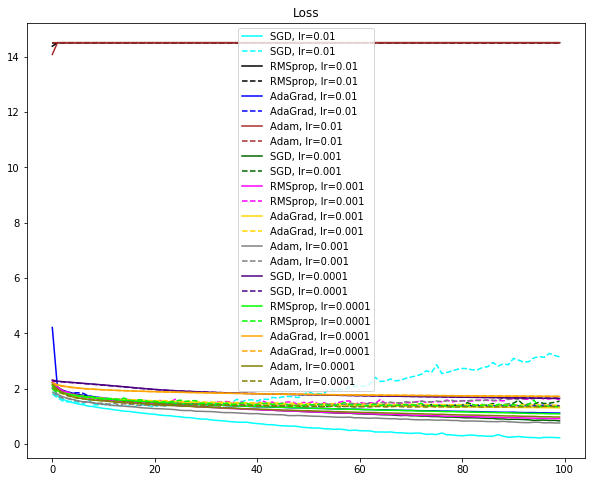

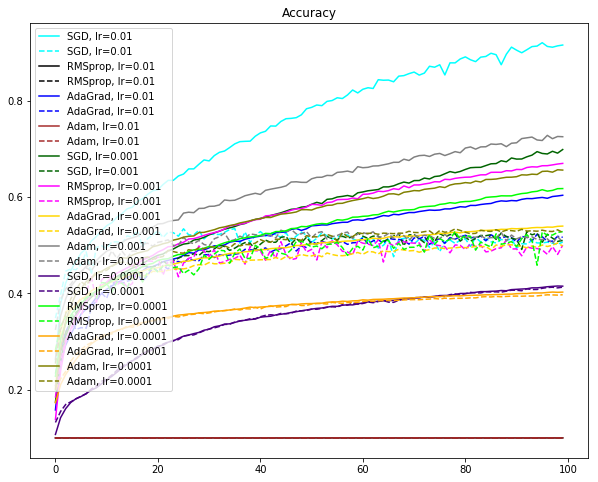

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ['aqua','black','blue','brown',
            'darkgreen','fuchsia','gold','grey',
            'indigo','lime','orange','olive',
            'teal','tan','purple','red']

plt.figure(figsize=(10, 8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()
